**Marco Pintore**

**email: marcopintore0@gmail.com**


Before coding, some useful imports:

These libraries are common through the challenges. For each challenge, additional libraries will be included at the beginning of each script.

In [ ]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import copy
from collections import defaultdict
from collections import Counter

# Challenge 1:  
Part of the text from MsTeams:

Extend the function make_gaussian_dataset that we implemented in lab02 to handle
arbitrary covariance matrices. In particular, implement the function  
make_gaussian_dataset_cov(n, mu, cov)
that takes as input: -
n: a vector containing the number of samples per each class; - -
mu: a matrix n_classes x n_features containing the centroid of each class (as a row vector);
cov: a tensor of size n_classes x n_features x n_features, such that cov[k, :, :] returns the
covariance matrix of class k.

### Necessary background: Affine transformation of the multivariate normal
To solve the exercise, we have to understand what it means transform a multivariate normal distribution into a new normal distribution.
To apply the transformation, we have to apply the so-called "affine transformation".
If $X$ is normally distributed and $X' = VX + \mu$ with $V$ a linear transformation (e.g. translation, rotation) and $\mu$ a vector, then also $X'$ is normally distributed with mean $\mu' = V\mu_{X} + \mu$ and covariance matrix $\Sigma' = V\Sigma_{X}V^T$.

So we can write:
$$X' \sim \mathcal{N}(\mu', \Sigma') \quad\quad X \sim \mathcal{N}(\mu_{X}, \Sigma_{X}) \\
\mathcal{N}(\mu', \Sigma') = \mathcal{N}(\mu + V\mu_{X}, V\Sigma_{X}V^T) = V\mathcal{N}(\mu_{X}, \Sigma_{X}) + \mu$$

To prove the new mean $\mu'$ and the new covariance matrix $\Sigma'$, we can compute them as follows:

$$\mu' = \mathbb{E}[X'] = \mathbb{E}[VX + \mu] = \mathbb{E}[VX] + \mu = V\mu_{X} + \mu$$

$$\begin{split}
\Sigma' & = \mathbb{E}[(Y-\mu')(Y-\mu')^\top] \\
           & = \mathbb{E}[(VX+\mu - V\mu_{X}-\mu)(VX+\mu - V\mu_{X}-\mu)^\top] \\
           & = \mathbb{E}[(V(X-\mu_{X})) (V(X-\mu_{X}))^\top] \\
           & = \mathbb{E}[V(X-\mu_{X}) (X-\mu_{X})^\top V^\top] \text{ - Property }(A\cdot B)^\top =  B^\top \cdot A^\top\\
           & = V\mathbb{E}[(X-\mu_{X})(X-\mu_{X})^\top]V^\top \\
           & = V\Sigma_{X}V^\top
\end{split}$$



### Sampling from a multivariate normal

The previous paragraph helps us to sample from generic Gaussian distribution.
We can take the standard normal distribution with hyperparameters $\Sigma = I_n$ and $\mu=0$ provided by Numpy, and then directly apply the transformation defined above in order to sample from a generic multivariate normal distribution.

In order to find the "transformation matrix", we can choose between two approaches:
1. Standard eigenvalue decomposition;
2. Cholesky decompostion.

To do this challenge, I prefer to use the first approach.

For example, let's take a covariance matrix like this:
$Σ = \begin{pmatrix}
5 & 0 \\
0 & 1
\end{pmatrix}
$

The matrix $Σ$ has two eigenvalues $λ_1=5, λ_2=1$ and two eigenvector   $v_1 = (x1,x2) = t (1,0) \text{ and } v_2 = (x1,x2) = t (0,1)$.
The eigenvector define the direction where our data are spread, whereas the eigenvalues tell us how much the data are "spread" along the corresponding eigenvector.


On the other hand, when the covariance matrix is "generic," we can say that our matrix has received a linear transformation.

In the general case, we will try to decompose the covariance matrix into the product of rotation and scaling matrices, attempting to represent the covariance matrix as a function of its eigenvectors and eigenvalues (we can do that, due to the "Spectral Theorem" and the symmetric proprerites of the covariance matrix).

So we can decompose the covariance matrix as follows:
$$\begin{split}
  \Sigma & = U D U^{-1} \\
           & = UD^{\frac{1}{2}} D^{\frac{1}{2}} U^{-1} \\
           & = V V^\top
\end{split}
$$

Where $V = UD^{\frac{1}{2}}$ and $U^{-1}$ is an orthogonal matrix (so  $U^{-1}$ =  $U^\top$) made up of the eigenvectors of matrix $Σ$

Finally, we can verify that choosing the standard normal distribution (with uncorrelated data), since $Σ_{X} = I_n$, our relation written on the "Necessary Background: Affine transformation of the multivariate normal becomes:
$$\begin{split}
\Sigma' & = V\Sigma_{X}V^\top \\
           & = V V^\top
\end{split}
$$

And that's exactly what we were looking for for the transformation.

References:
- https://cs229.stanford.edu/section/gaussians.pdf
- https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/
- https://peterroelants.github.io/posts/multivariate-normal-primer/
- https://github.com/peterroelants/peterroelants.github.io/blob/main/notebooks/misc/multivariate-normal-primer.ipynb
- https://rinterested.github.io/statistics/multivariate_gaussian.html

**Challenge 1 - Implementation of make_gaussian_dataset_cov**

Estimated covariance of class 0: [[ 1.93152224 -0.28595772]
 [-0.28595772  0.91405077]]
Estimated covariance of class 1: [[0.99663096 0.41538193]
 [0.41538193 0.85791592]]


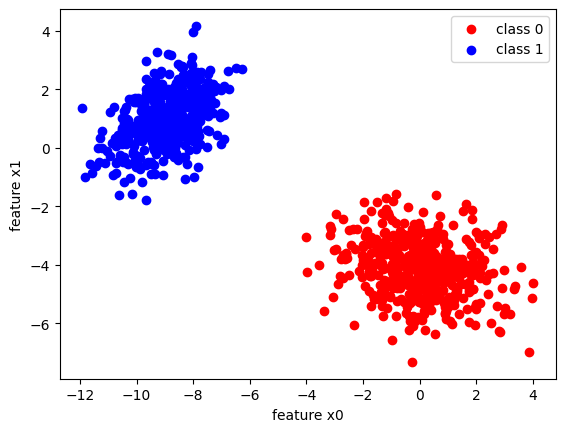

In [ ]:
def plot_dataset(x, y, feat_1=0, feat_2=1, legend=True):
    n_classes = len(np.unique(y))
    colors = ['r', 'b', 'k', 'g', 'c', 'm', 'y']

    for y0 in range(n_classes):
        x0 = x[y == y0, feat_1]  # y0 is the selected class within the loop
        x1 = x[y == y0, feat_2]
        plt.scatter(x0, x1, c=colors[y0], label='class ' + str(y0))
    if legend:
      plt.legend()
    plt.xlabel('feature x' + str(feat_1))
    plt.ylabel('feature x' + str(feat_2))

    return

# check function, the covariance matrix must be semidefinite positive
def is_semidefinite_positive(eigvalues):
  # check whether all eigenvalues are greater or equal to 0 (non-negative)
  return True if np.all((eigvalues >= 0)) else False


# decomposition of the covariance matrix through spectral decomposition
def covariance_matrix_decomposition(cov):
    '''
    Decompose a covariance matrix in the form V*V^T, returning the V matrix.
    The cov matrix should be positive definite
    :param cov: a matrix containing one covariance matrix (one class)
    '''
    cov = np.array(cov)

    # The eig function of numpy returns the value of eigenvector
    # normalized (divided by the Euclidian norm of the eigenvector l-2),
    # so it seems wrong compared to the paper and pen calculus
    eigenvalues, eigenvectors = LA.eig(cov)

    # check if the matrix is positive semi-definite
    if not is_semidefinite_positive(eigenvalues):
      raise Exception('The matrix is not positive semi-definite')

    # make a diagonal matrix with the eigenvalues into the diagonal
    eig_value_diag = np.diag(eigenvalues)

    # compute the square of the above matrix
    eig_value_diag = np.sqrt(eig_value_diag)

    # compute the transformation matrix V = U*D^(1/2)
    V = np.matmul(eigenvectors,eig_value_diag)

    return V

def make_gaussian_dataset_cov(n, mu, cov):
    """
    Creates a k-class d-dimensional Gaussian dataset.
    :param n: vector containing the number of samples for each class
    :param mu: matrix containing the mean vector for each class
    :param cov: a matrix containing covariance matrices for each class
    :return: x,y, the gaussian dataset
    """

    n = np.array(n)  # convert to np.array if list is passed as input
    mu = np.array(mu)
    cov = np.array(cov)

    n_classes = mu.shape[0]  # number of classes
    n_features = mu.shape[1]  # number of features
    n_samples = n.sum()  # total number of samples

    # My code here:

    # allocate the space for both X (dataset) and y (labels)
    X = np.zeros(shape=(n_samples,n_features))
    y = np.zeros(shape=(n_samples,))

    # index used in training set assignments inside for loop
    idx = 0
    for k in range(n_classes):
        # generate n[k] samples from normal Gaussian Distribution
        z = np.random.randn(n[k], n_features)
        # Compute the V matrix useful to carry out a linear transformation
        # of a (Gaussian) random variable. V matrix is extracted from
        # covariance matrix given as a input of this function (cov param.)
        V = covariance_matrix_decomposition(cov[k])

        # apply the transformation x' = Vx + mu
        xk = z.dot(V.T) + mu[k,:]

        # assign the labels for this k class
        yk = k * np.ones(shape=(n[k]))

        # build the whole dataset
        X[idx:idx+n[k], : ] = xk
        y[idx:idx+n[k]] = yk
        idx += n[k]

    return X, y

centroids = [[0, -4],
            [-9, 1]]

cov = [[[2, -0.3],
        [-0.3, 1]],
       [[1, 0.5],
        [0.5, 1]]]

n_samples_per_class = [500, 500]

x, y = make_gaussian_dataset_cov(n_samples_per_class, centroids, cov)

print('Estimated covariance of class 0:', np.cov(x[y == 0, :].T))
print('Estimated covariance of class 1:', np.cov(x[y == 1, :].T))

plot_dataset(x, y)
plt.show()

# Challenge 2:
Text of the challenge:
1. Implement a kNN classifier and visualize its decision regions (as in Lab02/
Ex4).
2. Compare it with the sklearn implementation (https://scikitlearn.org/stable/modules/neighbors.html#classification)

The K nearest neighbors classifier is based on the number of k neighbors that our new model has.

The decision rule assigns to the new pattern x the class most present among the K points in the training set closest to x.
To calculate the distance of neighbors, one can calculate the Euclidean distance, Manhatthan distance, and so on. I'll use the Euclidian Distance.

**Challenge 2 - Point n.1 : Implementation of my Knn Classifier and visualization of its decision region**

(It'll be optimized later in the notebook)

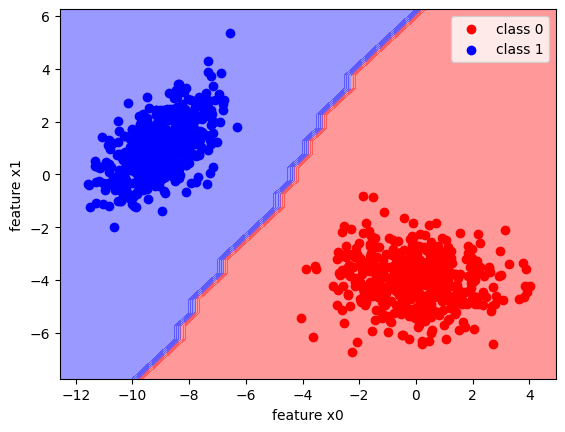

In [ ]:
################## Knn Classifier Class ##################
class CKNearestNeighbors:
  def __init__(self, k=3):
    self._k = k
    self._training_set = None
    self._labels = None

  @property
  def k(self):
    return self.k

  @k.setter
  def k(self, new_k):
    if new_k > 0:
      self._k = new_k
    else:
      raise ValueError("K must be > 0")

  def euclidian_distance(self, p, q):
    p = np.array(p)
    q = np.array(q)
    return np.sqrt(np.sum(np.power(p-q,2)))

  def fit(self, X, y):
    self._training_set = copy.deepcopy(X)
    self._labels = copy.deepcopy(y)

  def predict(self, new_patterns):
    predictions = []

    # Compute the distances between the new pattern and the entire dataset
    # then sort the distances and choose the k smallest
    for pattern in new_patterns:
        distances = []
        # iterate over the whole training set
        for idx_label, training_point in enumerate(self._training_set):
            # compute the distances with the new pattern (Euclidian distance in this case)
            dist = self.euclidian_distance(pattern, training_point)
            # distances will be like this :
            # distances = [[14.89841764019199, 0.0], [11.700261616241658, 1.0] ...]
            distances.append([dist, self._labels[idx_label] ])

        distances.sort()
        # pick the k smallest neighbors
        k_neighbors = distances[:self._k]

        # evaluate at which class belongs the k-neighbors
        # class_counter will be like this : {1.0: 1, 0.0: 2} <- prediction = 0
        class_counter = defaultdict(int)
        for elem in k_neighbors:
            label = elem[1]
            class_counter[label] += 1

        # finally compute the most common label and do the prediction
        most_common_label = max(class_counter, key=lambda k: class_counter[k])
        predictions.append(most_common_label)

    return np.array(predictions)

################## End Knn Classifier Class ##################


# The next lines are useful to visualize the
# decision region of my Knn Classifier

# Function useful to plot the decision region
def plot_decision_regions(x, y, classifier, resolution=0.5, legend=True):
    # setup marker generator and color map
    colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

    plot_dataset(x,y)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    return

# Define the centroids of the data
centroids = [[0, -4],
            [-9, 1]]

# Define covariance's matrix tensor
cov = [[[2, -0.3],
        [-0.3, 1]],
        [[1, 0.5],
        [0.5, 1]]]

# Define the number of samples for each class
n_samples_per_class = [500, 500]

# Create a Gaussian dataset with the function defined in the challenge n.1
x, y = make_gaussian_dataset_cov(n_samples_per_class, centroids, cov)

# Instantiate my Knn
clf = CKNearestNeighbors(3)

# Train Knn
clf.fit(x, y)

# Visualize its decision regions (as in Lab02/ Ex4)
plot_decision_regions(x, y, clf)
plt.show()

**Challenge 2 - Point n.2 : Compare the Knn Classifier with the sklearn implementation**

To carry out the compairison, I'll do the following steps:
- Prepare two Gaussian Dataset (one for train and one for test) with the function written in the Challenge n.1;
- Train both my Knn Classifier and the one provided by sklearn;
- Test the classifiers against the test points, then compare the predictions;
- Display the decision regions, in order to have a qualitative measure.

*This steps are not necessarily exhaustive for comparison*

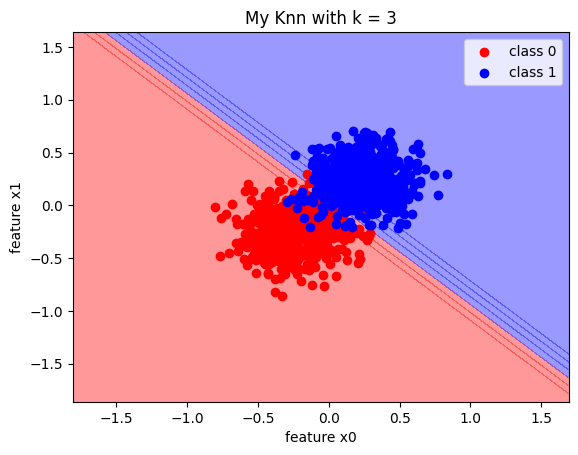

Classification accuracy:  0.9577777777777777


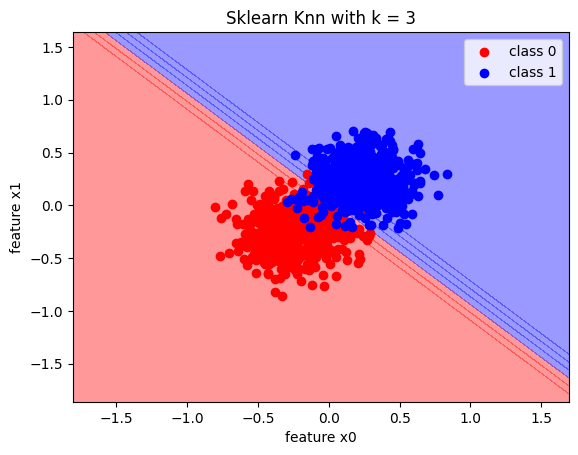

Classification accuracy:  0.9577777777777777
#########################################
Do My Knn make the same predictions of the SkLearn Knn classifier at test time?
The test has been carried out with n.450 samples. Did we get the same predictions on the two classifiers? Result = True
#########################################


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

centers = [[-0.25,-0.25], [0.25,0.25]]
dataset_X, dataset_y = make_blobs(n_samples=1500, n_features=2, centers=centers, cluster_std=0.2, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=0.3, random_state=42)

k_knn = 3

classifiers = {'My Knn' : CKNearestNeighbors(k_knn),
               'Sklearn Knn' : KNeighborsClassifier(k_knn)}
# predictions_dict is a dict useful to compare the prediction between my knn and sklearn knn
predictions_dict = {}

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    # predict the labels and assign it to predictions_dict
    y_pred = clf.predict(X_test)
    predictions_dict[clf_name] = y_pred

    # plot operations
    plot_decision_regions(X_train, y_train, clf)
    plt.title(f"{clf_name} with k = {k_knn}")
    plt.show()
    print('Classification accuracy: ', np.mean(y_pred == y_test))

# Check whether the prediction are the same or not
print("#########################################")
print("Do My Knn make the same predictions of the SkLearn Knn classifier at test time?")
same_predictions = np.array_equal(predictions_dict['My Knn'], predictions_dict['Sklearn Knn'])
print(f"The test has been carried out with n.{X_test.shape[0]} samples. Did we get the same predictions on the two classifiers? Result = {same_predictions}")
print("#########################################")

**Drawback of my own implementation of Knn Classifier**

In the previous implementation, I've not exploited the potentiallity of Numpy.

Now I want to use inheritance and override the predict method. I will use Numpy to speed up vector and matrix calculations.

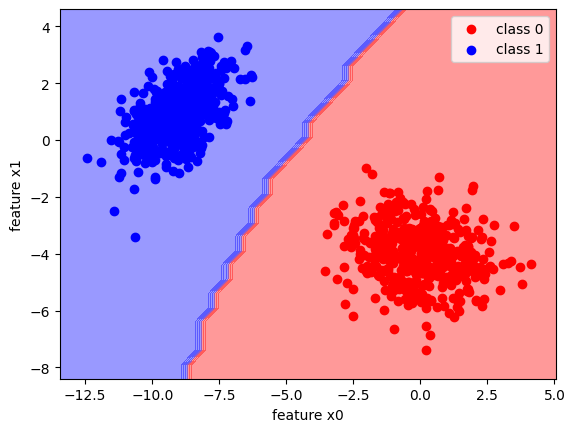

In [ ]:
class Optimized_KNearestNeighbors(CKNearestNeighbors):
  def predict(self, new_patterns):
    predictions = []
    labels = np.array(self._labels)

    for pattern in new_patterns:
        distances = (self._training_set - pattern)**2
        distances = np.sum(distances, axis=1)
        distances = np.sqrt(distances)

        # sort the distances
        distances = np.argsort(distances)

        # extract the k_neighbors
        k_neighbors = labels[distances[:self._k]]
        class_counter = Counter(k_neighbors)

        # compute the most common label from class_counter
        most_common_label = max(class_counter, key=lambda k: class_counter[k])
        predictions.append(most_common_label)
    return np.array(predictions)

# Create a Gaussian dataset with the function defined in the challenge n.1
x, y = make_gaussian_dataset_cov(n_samples_per_class, centroids, cov)

clf = Optimized_KNearestNeighbors(3)

# Train Knn
clf.fit(x, y)

# Visualize its decision regions (as in Lab02/ Ex4)
plot_decision_regions(x, y, clf)
plt.show()


# Challenge 3

Visualize the decision regions of different classification algorithms from sklearn on a couple of
different two-class classification problems. Use also the NearestMean classifier
implementation from our Python lab, and your kNN implementation from Challenge 2.


To solve this challenge, I'll use different toy dataset from Sklearn and the gaussian dataset written in the challenge n.1:
- make_moons;
- make_circles;
- make_gaussian_dataset_cov.

Here I report the NMC Classifier built in the previous labs (taken from https://github.com/unica-ml/ml/blob/master/notebooks/lab02.ipynb)

**Nmc Classifier**

In [ ]:
# NMC Classifier
from sklearn.metrics import pairwise_distances

class CNearestMeanClassifier:
    """Class implementing a nearest mean classifier"""

    def __init__(self):
        self._centroids = None
        return

    @property
    def centroids(self):
        return self._centroids

    def fit(self, X, Y):
        n_classes = np.unique(Y).size
        n_features = X.shape[1]
        self._centroids = np.zeros(shape=(n_classes, n_features))
        for k in range(n_classes):
            self._centroids[k, :] = np.mean(X[Y==k, :], axis=0)
        return self

    def predict(self, X):
        d = pairwise_distances(X, self._centroids)
        y_pred = np.argmin(d ,axis=1)
        return y_pred


**Challenge 3 - Visualize the decision regions of different classification algorithms**

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


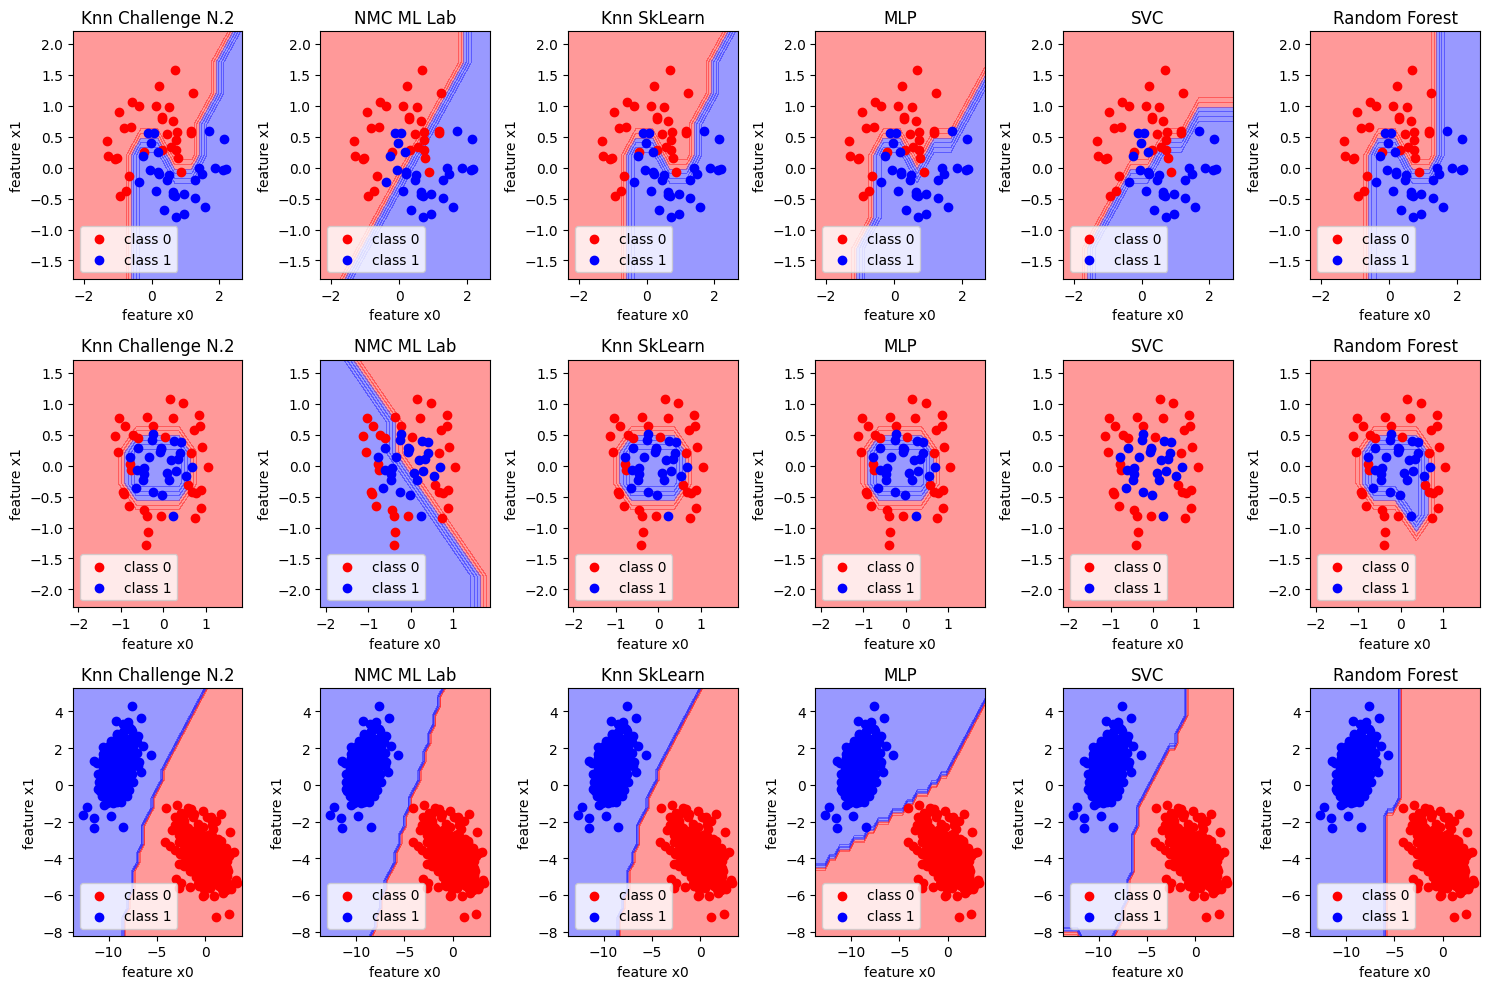

In [ ]:
# Challenge n.3
from sklearn.datasets import make_circles, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# cenotroids, cov and n_samples_per_class for make_gaussian_dataset_cov
centroids = [[0, -4],
            [-9, 1]]

cov = [[[2, -0.3],
        [-0.3, 1]],
        [[1, 0.5],
        [0.5, 1]]]

n_samples_per_class = [500, 500]

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    make_gaussian_dataset_cov(n_samples_per_class, centroids, cov)
]

# Define the classifiers that we want to test
k_knn = 3
classifiers = {
    'Knn Challenge N.2' : Optimized_KNearestNeighbors(k_knn),
    'NMC ML Lab' : CNearestMeanClassifier(),
    'Knn SkLearn' : KNeighborsClassifier(k_knn),
    'MLP' : MLPClassifier(max_iter=1000),
    'SVC' : SVC(gamma=0.1),
    'Random Forest' : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
}

# new figure with height=5, width=10
plt.figure(figsize=(15,10))

for ds_cnt, ds in enumerate(datasets):
    # pick the i-th dataset (called ds)
    X, y = ds
    # subdivide our dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    for clf_cnt, (name, clf) in enumerate(classifiers.items()):
        # train the classifier
        clf.fit(X_train, y_train)

        # the last param is a index and len(classifiers)*ds_cnt is a "shift"
        # for every row. plt.subplot create a subplot made up of len(dataset)*len(classifier) figures
        plt.subplot(len(datasets), len(classifiers), clf_cnt + 1 + len(classifiers) * ds_cnt)
        plot_decision_regions(X_train, y_train, clf)
        plt.title(name)


plt.tight_layout()
plt.show()

# Challenge 4

- Consider different classification algorithms from sklearn and evaluate their performance on
the MNIST digit data. You can use the corresponding data loader from sklearn: https://scikitlearn.org/stable/modules/generated/sklearn.datasets.load_digits.html. It is a dataset
containing images of the digits from 0-9 (10 classes).
Recall that each algorithm has to be trained and tested on different training and test data
samples to avoid an optimistic evaluation of its performance.
- Draw a plot in which you show, for each algorithm, how the testing accuracy varies as a
function of the number of training samples.  
o This plot will contain a line for each classifier and will display test accuracy (y-axis) vs
number of training samples (x-axis).

**Challange 4 - Load Dataset with ``` load_digits ``` from sklearn and visualize our dataset**



(1797, 64)
(1797,)
How many digits we have for each class :  {0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


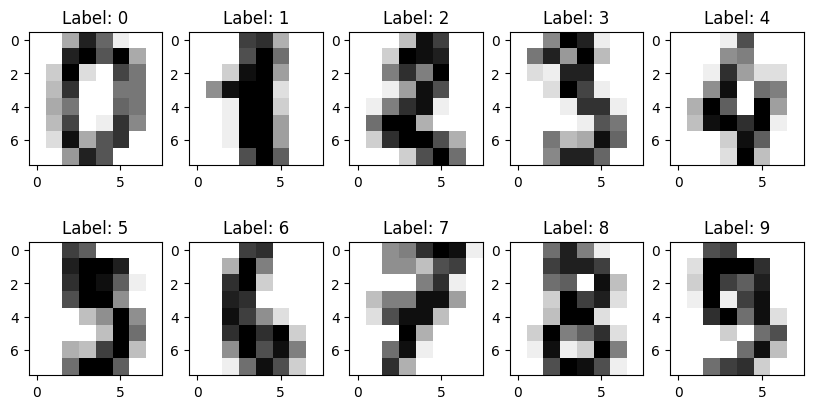

In [ ]:
from sklearn.datasets import load_digits

def load_mnist_data():
    """This function returns MNIST handwritten digits and labels as ndarrays."""
    # The variable digits has two attributes: digits.images and digits.target
    # digits.images = MNIST images, digits.target = labels
    digits = load_digits()
    return digits.data, digits.target

# Thanks Isde UniCa course for these functions
def plot_image(im, shape=(8,8)):
    '''Plot one image after reshaping.'''
    im = im.reshape(shape)  # reshape the digit to be 8x8
    plt.imshow(im, cmap='binary')

def plot_ten_images(x, y, shape=(8,8)):
    '''Plot the first ten images from x in a 2x5 plot, after reshaping.'''
    plt.figure(figsize=(10,5))  # new figure with height=5, width=10
    for i in range(10):
        plt.subplot(2, 5, i+1)
        image = x[i, :]
        plot_image(image, shape=shape)
        plt.title("Label: " + str(y[i]))

def count_number_class(y):
  num_classes = np.unique(y).size
  counts = {}

  for i in range(num_classes):
      counts[i] = np.array(y==i).sum()

  return counts

x, y = load_mnist_data()
plot_ten_images(x,y,shape=(8,8))
print(x.shape)
print(y.shape)
print('How many digits we have for each class : ', count_number_class(y))

As suggested by the descritpion of the challenge, we should use different train and test set for each iteration. So I create a data set, with the same data set I will check each model, then at the next iteration I will generate another data set and so on.

**Challange 4 - Accuracy against n.training samples**

Our dataset has a shape of (1797, 64)
Test n.0 - train samples n.179 - % of dataset used for training n.10.0
Nearest Neighbors classifier, accuracy = 93.60000000000001%
MLP classifier, accuracy = 91.8%
SVC classifier, accuracy = 96.0%
Random Forest classifier, accuracy = 87.1%


Test n.1 - train samples n.339 - % of dataset used for training n.18.9
Nearest Neighbors classifier, accuracy = 95.0%
MLP classifier, accuracy = 92.9%
SVC classifier, accuracy = 96.8%
Random Forest classifier, accuracy = 86.7%


Test n.2 - train samples n.499 - % of dataset used for training n.27.800000000000004
Nearest Neighbors classifier, accuracy = 97.6%
MLP classifier, accuracy = 95.1%
SVC classifier, accuracy = 98.4%
Random Forest classifier, accuracy = 91.0%


Test n.3 - train samples n.659 - % of dataset used for training n.36.7
Nearest Neighbors classifier, accuracy = 98.2%
MLP classifier, accuracy = 93.60000000000001%
SVC classifier, accuracy = 98.4%
Random Forest classifier, accuracy = 92.9%


Test n

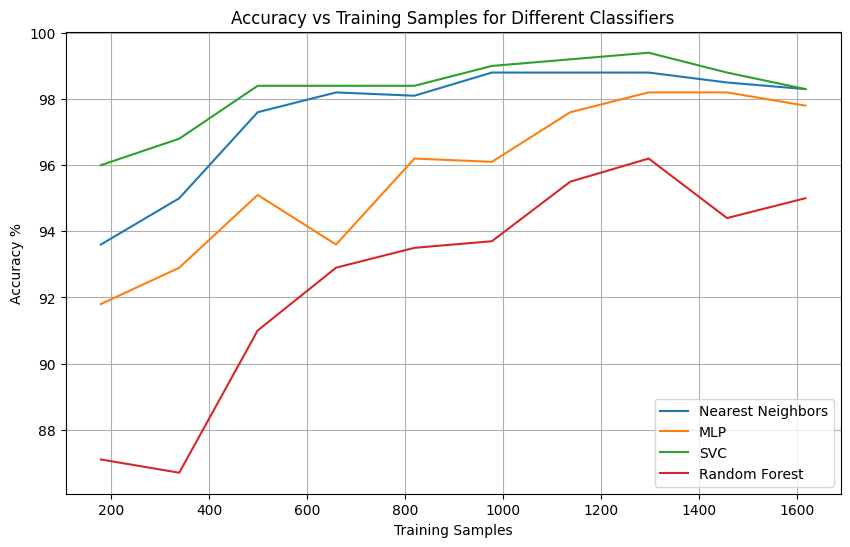

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

print(f'Our dataset has a shape of {x.shape}')

# Train size goes from 10% to 90%
num_test = 10
train_sizes = np.linspace(0.1, 0.9, num_test).round(3)

# Define the classifiers that we want to test
classifiers = {
    'Nearest Neighbors' : KNeighborsClassifier(3),
    'MLP' : MLPClassifier(max_iter=300),
    'SVC' : SVC(gamma=0.001),
    'Random Forest' : RandomForestClassifier(max_depth=10, n_estimators=10)
}

# The variable 'scores' is useful to keep track of the values to I'll display
# in a 2D plot (accuracy as a function on training samples size).

# Scores is going to be like this:
# {'SVC': {'accuracy': [95.42645241038319, 97.0303867403315] 'training_samples': [179, 349]}}
# It seems overcomplicated, but is useful in order to separe visualization and computation
scores = {clf : {'accuracy':[] , 'training_samples':[]} for clf in classifiers.keys()}

# iterate over each train value in train_sizes vector
for i, train_value in enumerate(train_sizes):
  # Split our dataset in training and test. For each iteration, this split is random
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 1-train_value)
  n_samples = X_train.shape[0]
  # some debugging information
  print(f'Test n.{i} - train samples n.{n_samples} - % of dataset used for training n.{100*train_value}')

  # for loop : for each classifier, there is a training, a test and
  # an accuracy evaluation
  for clf_name, clf in classifiers.items():

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = 100*(y_test==y_pred).mean().round(3)
    print(f'{clf_name} classifier, accuracy = {accuracy}%')

    # Prepare scores to visualize accuracy against training samples
    scores[clf_name]['accuracy'].append(accuracy)
    scores[clf_name]['training_samples'].append(n_samples)

  print('\n')


# Let's visualize our data collected during training and test time

print(scores)

plt.figure(figsize=(10, 6))
for clf_name in classifiers:
    plt.plot(scores[clf_name]['training_samples'], scores[clf_name]['accuracy'], label=clf_name)
plt.xlabel('Training Samples')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs Training Samples for Different Classifiers')
plt.legend()
plt.grid(True)
plt.show()